In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# reflect an existing database into a new model and tables
Base = automap_base()
Base.prepare(engine, reflect=True)
# view classes found by automap
Base.classes.keys()

['measurement', 'station']

In [7]:
# Create the inspector and connect it to the engine. Collect names to double check
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date: {most_recent_date[0]} .")

The most recent date: 2017-08-23 .


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database

last_twelve_months = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
last_twelve_months = dt.datetime.strptime(last_twelve_months[0], '%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
querydate = dt.date(last_twelve_months.year -1, last_twelve_months.month, last_twelve_months.day)
sel = [Measurement.date, Measurement.prcp]

# Save the query results as a Pandas DataFrame and set the index to the date column
queryresult = session.query(*sel).filter(Measurement.date >=querydate).all()
precipitation = pd.DataFrame(queryresult, columns =['Date', 'Precipitation'])

# Drop non value entries
precipitation = precipitation.dropna(how='any')

# Sort the dataframe by date
precipitation = precipitation.sort_values(["Date"], ascending = True)
precipitation = precipitation.set_index("Date")
precipitation.head(10)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
2016-08-23,1.79
2016-08-24,1.22
2016-08-24,0.08
2016-08-24,2.15


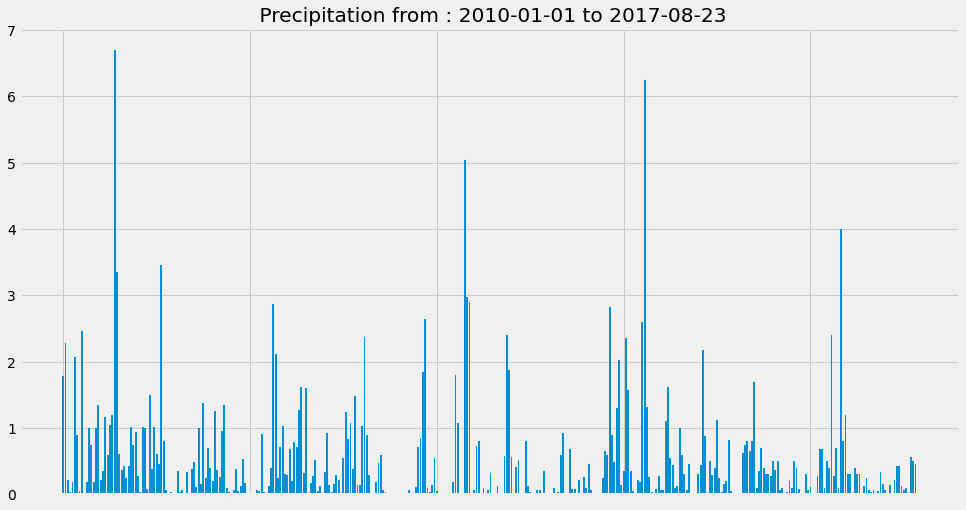

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data

xx = precipitation.index.tolist()
yy = precipitation['Precipitation'].tolist()


plt.figure(figsize = (15,8))
plt.bar(xx,yy)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)

majorticks = np.arange(0,400,80)
plt.xticks(majorticks)
plt.title(f" Precipitation from : 2010-01-01 to 2017-08-23")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.*use func
sel = [Measurement.station,func.count(Measurement.id)]

active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calcu(late the lowest, highest, and average temperature.
most_active_station = (session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs),).filter(Measurement.station == active_stations[0][0]).all())    
most_active_station

[(54.0, 85.0, 71.66378066378067)]

In [22]:
#Print statements for higest, avg, and lowest temp in the most active station.
print(f"*******The lowest temp is:{most_active_station[0][0]}F , the highest temp is :{most_active_station[0][1]}F, and the average temp is:{most_active_station[0][2]} F.")
print(f"*******The most active station was {active_stations[0][0]} - {active_stations[0][1]}.")


*******The lowest temp is:54.0F , the highest temp is :85.0F, and the average temp is:71.66378066378067 F.
*******The most active station was USC00519281 - 2772.


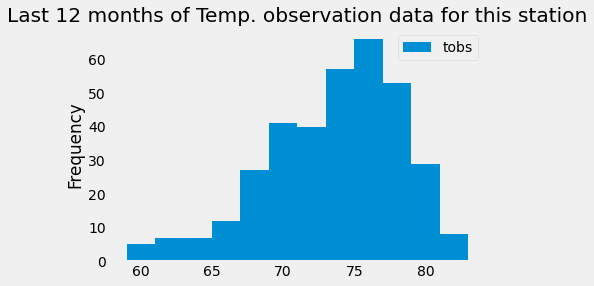

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == active_stations[0][0]).\
    filter(Measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == active_stations[0][0],"Name"].tolist()[0]

# n, b
# plot
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Last 12 months of Temp. observation data for this station")
plt.legend()

# Close session

In [27]:
# Close Session
session.close()